In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset_q1 import CustomTimeSeriesDataset, weighted_sampler_dataloader
from model_q4 import get_feature_extractor, transfer_model
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import os
from sklearn.metrics import roc_curve,roc_auc_score

In [2]:
dataset_test = CustomTimeSeriesDataset('ptbdb_test.csv', NetType="CNN")
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = get_feature_extractor()
feature_extractor.to(device)

model = transfer_model(feature_extractor)
model.to(device)

transfer_model(
  (base_model): ResCNN(
    (conv1): Conv1d(1, 24, kernel_size=(5,), stride=(3,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (resblock1): ResBlock(
      (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ELU(alpha=1.0)
    )
    (resblock2): ResBlock(
      (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ELU(alpha=1.0)
    )
   

In [4]:
# Function to extract the performance metrics
def performance_metrics(y_test,y_pred):
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    roc_auc = round(roc_auc_score(y_test, y_pred),4)

    #calculate optimal roc auc threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    y_optimal = y_pred>optimal_threshold

    #compute f1 score, precision recall AUC, balanced accuracy
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    pr_auc = metrics.auc(recall, precision)

    f1 = metrics.f1_score(y_test, y_optimal)
    balanced_accuracy =metrics.balanced_accuracy_score(y_test, y_optimal)
    return f1, pr_auc, balanced_accuracy, roc_auc

STRATEGY A
Balanced accuracy: 0.9822
F1-score: 0.9883
ROC AUC score: 0.9956
PR AUC score: 0.9976
-----------------------------------
STRATEGY B
Balanced accuracy: 0.9897
F1-score: 0.9924
ROC AUC score: 0.9964
PR AUC score: 0.998
-----------------------------------
STRATEGY C
Balanced accuracy: 0.9682
F1-score: 0.9799
ROC AUC score: 0.9915
PR AUC score: 0.9959
-----------------------------------


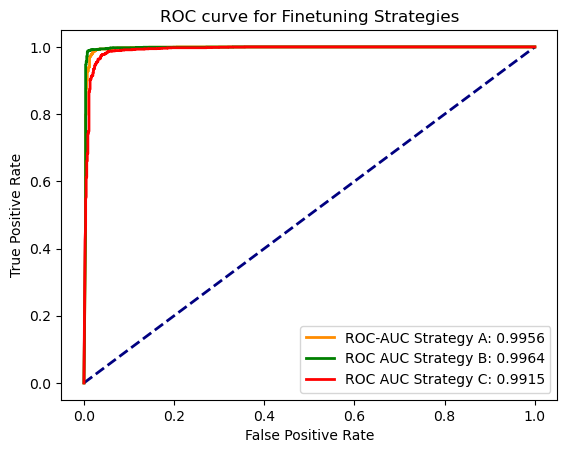

In [6]:
### TASK A
# Load model parameters
model.load_state_dict(torch.load('transfer_model_A_16batch_100epochs_best_parameters.pth'))
# Evaluation
model.to(device)
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).detach().cpu().numpy()
        labels=labels.detach().cpu().numpy()

# Balanced accuracy, f1-score, roc_auc_score, pr_auc_score
print("STRATEGY A")
f1, pr_auc, balanced_accuracy, roc_auc = performance_metrics(labels, outputs)
print('Balanced accuracy:', np.round(balanced_accuracy,4))
print('F1-score:', np.round(f1,4))
print('ROC AUC score:', np.round(roc_auc,4))
print('PR AUC score:', np.round(pr_auc,4))
print('-----------------------------------')

#Plot ROC curve
fpr, tpr, _ = roc_curve(labels, outputs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,label=f'ROC-AUC Strategy A: {roc_auc}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.gca().set_xlabel('False Positive Rate')
plt.gca().set_ylabel('True Positive Rate')
plt.title('ROC curve for Finetuning Strategies')

### TASK B
# Load model parameters
model.load_state_dict(torch.load('transfer_model_B_16batch_100epochs_best_parameters.pth'))
# Evaluation
model.to(device)
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).detach().cpu().numpy()
        labels=labels.detach().cpu().numpy()

# Balanced accuracy, f1-score, roc_auc_score, pr_auc_score
print("STRATEGY B")
f1, pr_auc, balanced_accuracy, roc_auc = performance_metrics(labels, outputs)
print('Balanced accuracy:', np.round(balanced_accuracy,4))
print('F1-score:', np.round(f1,4))
print('ROC AUC score:', np.round(roc_auc,4))
print('PR AUC score:', np.round(pr_auc,4))
print('-----------------------------------')

#Plot ROC curve
fpr, tpr, _ = roc_curve(labels, outputs)

plt.gca().plot(fpr, tpr, color='green', lw=2,label=f'ROC AUC Strategy B: {roc_auc}')

### TASK C
# Load model parameters
model.load_state_dict(torch.load('transfer_model_C_16batch_100epochs_best_parameters.pth'))
# Evaluation
model.to(device)
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).detach().cpu().numpy()
        labels=labels.detach().cpu().numpy()

# Balanced accuracy, f1-score, roc_auc_score, pr_auc_score
print("STRATEGY C")
f1, pr_auc, balanced_accuracy, roc_auc = performance_metrics(labels, outputs)
print('Balanced accuracy:', np.round(balanced_accuracy,4))
print('F1-score:', np.round(f1,4))
print('ROC AUC score:', np.round(roc_auc,4))
print('PR AUC score:', np.round(pr_auc,4))
print('-----------------------------------')

#Plot ROC curve
fpr, tpr, _ = roc_curve(labels, outputs)

plt.gca().plot(fpr, tpr, color='red', lw=2,label=f'ROC AUC Strategy C: {roc_auc}')


plt.legend(loc="lower right")
plt.show()

